<a href="https://colab.research.google.com/github/Trcty/abstract-classification/blob/main/skim_abstract_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helper functions



In [2]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [3]:
def split_chars(text):
  return " ".join(list(text))

In [4]:
def prep_text(filename):
  input = get_lines(filename) 
  abstract_diction = [] 
  total="".join(input).split("###")
  abstracts=list(filter(None, total))

  for abstract in abstracts:
    abstract_lines=abstract.splitlines()
    abstract_lines=list(filter(None, abstract_lines))
    for abstract_line_number, abstract_line in enumerate(abstract_lines[1:]):
        line_data = {} 
        label_text_split = abstract_line.split("\t") 
        line_data["label"] = label_text_split[0]
        line_data["text"] = label_text_split[1].lower() 
        line_data["line_number"] = abstract_line_number+1 
        line_data["total_lines"] = len(abstract_lines) - 1
        abstract_diction.append(line_data) 
  return abstract_diction

In [5]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  results = {"accuracy": accuracy,
                  "precision": precision,
                  "recall": recall,
                  "f1": f1}
  return results

In [6]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Download and explore data

In [7]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [8]:
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [9]:
data_20k="pubmed-rct/PubMed_20k_RCT"

In [10]:
import os
filenames = [data_20k + '/'+ filename for filename in os.listdir(data_20k)]
filenames

['pubmed-rct/PubMed_20k_RCT/train.txt',
 'pubmed-rct/PubMed_20k_RCT/dev.txt',
 'pubmed-rct/PubMed_20k_RCT/test.txt']

In [11]:
train_data=get_lines('pubmed-rct/PubMed_20k_RCT/train.txt')
train_data[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

In [12]:
train=prep_text('pubmed-rct/PubMed_20k_RCT/train.txt')
test=prep_text('pubmed-rct/PubMed_20k_RCT/test.txt')
val=prep_text('pubmed-rct/PubMed_20k_RCT/dev.txt')

In [13]:
train[:3]

[{'label': 'OBJECTIVE',
  'line_number': 1,
  'text': 'to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 12},
 {'label': 'METHODS',
  'line_number': 2,
  'text': 'a total of 125 patients with primary knee oa were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'total_lines': 12},
 {'label': 'METHODS',
  'line_number': 3,
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 12}]

# visualize data in dataframe and check summary statistics 

In [14]:
import pandas as pd
train_df=pd.DataFrame(train)
test_df=pd.DataFrame(test)
val_df=pd.DataFrame(val)
train_df.head(6)

,label,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of 6 weeks of dail...,1,12
1,METHODS,a total of 125 patients with primary knee oa w...,2,12
2,METHODS,outcome measures included pain reduction and i...,3,12
3,METHODS,pain was assessed using the visual analog pain...,4,12
4,METHODS,secondary outcome measures included the wester...,5,12
5,METHODS,"serum levels of interleukin 1 ( il-1 ) , il-6 ...",6,12


## Distribution of labels in train

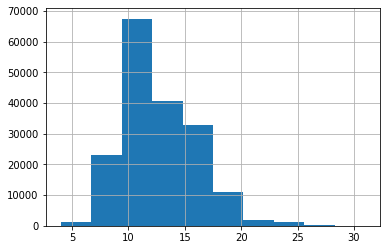

In [15]:
train_df['total_lines'].hist()

## max, mean sentence length in training data and 95 percentile

In [16]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
length=[len(i.split(' ')) for i in train_sentences]
percentile=int(np.percentile(length, 95))
max(length),np.mean(length),percentile

(296, 26.338435903132638, 55)

# prepare data

## use onehotencoder

In [18]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse=False)
train_label=encoder.fit_transform(train_df['label'].to_numpy().reshape(-1,1))
val_label=encoder.transform(val_df['label'].to_numpy().reshape(-1,1))
test_label=encoder.transform(test_df['label'].to_numpy().reshape(-1,1))

## use labelencoder 

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labelencode = label_encoder.fit_transform(train_df["label"].to_numpy())
val_labelencode = label_encoder.transform(val_df["label"].to_numpy())
test_labelencode = label_encoder.transform(test_df["label"].to_numpy())
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# baseline model (naive_bayes)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])
model_0.fit(X=train_sentences, 
            y=train_labelencode)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0_result=calculate_results(val_labelencode,model_0.predict(val_sentences))
model_0_result

{'accuracy': 0.7317291142592347,
 'f1': 0.7058060715307974,
 'precision': 0.7315166696974572,
 'recall': 0.7317291142592347}

# model 1:  Dense layer with custom token embedding

## create vectorizor 

In [22]:
import numpy 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_vocab_size=68000
vectorizer=TextVectorization(max_tokens=max_vocab_size,output_sequence_length=percentile)
vectorizer.adapt(train_sentences)

In [23]:
# view random sample sentence and its vectorized form 
import random
sample=random.choice(train_sentences)
vectorized_sample=vectorizer([sample])
sample, len(sample.split()), vectorized_sample

('inhalation of no and oxygen improved cto in ph. in multivariate regression analysis cto at maximal exercise predicted the work load achieved when controlled for age , pulmonary vascular resistance and mixed venous oxygen saturation ( r ( 2 ) = .419 , p < .000 ) ; in addition , the 6mwd was predicted by cto ( adjusted r ( 2 ) = .511 , p < .000 ) .',
 71,
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[2549,    4,   35,    3,  671,  182, 9791,    5, 1973,    5, 1109,
          416,   87, 9791,   15, 1471,  188,  907,    2,  756, 1449,  496,
          194,  112,   11,  107,  610,  825,  544,    3,  909, 1224,  671,
         2404,  632,   32, 7478,   14, 2322,    5,  358,    2, 8638,   10,
          907,   22, 9791,  444,  632,   32, 6310,   14, 2322,    0,    0]])>)

In [24]:
all_vocab_in_train=vectorizer.get_vocabulary()

## create custum embedding

In [25]:

from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=len(all_vocab_in_train), 
                             output_dim=128, 
                             mask_zero=True,
                             name="custum_embedding") 

In [26]:
embedded_sample=embedding(vectorized_sample)
embedded_sample

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.04733404,  0.02329589, -0.0395125 , ..., -0.03965784,
         -0.01710117,  0.04891947],
        [ 0.0342752 ,  0.02751504,  0.0211322 , ...,  0.03037309,
          0.01850061, -0.00180948],
        [ 0.04742518,  0.00649474, -0.02563961, ..., -0.01511499,
          0.02907989, -0.02730842],
        ...,
        [ 0.01643297, -0.02050866,  0.01188149, ...,  0.0329575 ,
          0.00119355, -0.0184075 ],
        [-0.00882169,  0.04555294, -0.02196983, ..., -0.03847699,
          0.03133491, -0.03872131],
        [-0.00882169,  0.04555294, -0.02196983, ..., -0.03847699,
          0.03133491, -0.03872131]]], dtype=float32)>

## prepare dataset

In [27]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_label))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_label))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## create and train the model

In [28]:
from tensorflow.python.keras import activations
from tensorflow.python.keras.layers.core import Dropout
model1=tf.keras.Sequential([
   layers.Input((1,),dtype=tf.string),
    vectorizer,
    embedding,
    layers.Dense(64, activation="relu"),
    layers.GlobalMaxPool1D(),
    layers.Dense(5, activation="softmax")
])
model1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [29]:
history_model1=model1.fit(train_dataset,
                          steps_per_epoch=int(0.3*len(train_dataset)),
                          epochs=3,
                          validation_data=valid_dataset,
                          validation_steps=int(0.3*len(valid_dataset)))

Epoch 1/3
1688/1688 [==============================] - 12s 6ms/step - loss: 0.6986 - accuracy: 0.7408 - val_loss: 0.5681 - val_accuracy: 0.7879
Epoch 2/3
1688/1688 [==============================] - 10s 6ms/step - loss: 0.5782 - accuracy: 0.7874 - val_loss: 0.5362 - val_accuracy: 0.7976
Epoch 3/3
1688/1688 [==============================] - 10s 6ms/step - loss: 0.5412 - accuracy: 0.8025 - val_loss: 0.5406 - val_accuracy: 0.8000


In [30]:
model1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5432 - accuracy: 0.8004


[0.5432484745979309, 0.8003773093223572]

In [31]:
model1_predict=model1.predict(valid_dataset)
model1_predict_result=tf.argmax(model1_predict,axis=1)
model_1_result=calculate_results(val_labelencode, model1_predict_result)
model_1_result

{'accuracy': 0.8003773335098636,
 'f1': 0.7942427252454866,
 'precision': 0.8098633882549283,
 'recall': 0.8003773335098636}

# Model 2: use pretrained embedding layer (universal sentence encoder) 

In [32]:
import tensorflow_hub as hub
uni_sen_encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [33]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = uni_sen_encoder(inputs) 
x = layers.Dense(64, activation="relu")(pretrained_embedding) 
outputs = layers.Dense(5, activation="softmax")(x) 
model_2 = tf.keras.Model(inputs=inputs,outputs=outputs)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.3*len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.3 * len(valid_dataset)))

Epoch 1/3
1688/1688 [==============================] - 128s 62ms/step - loss: 0.7083 - accuracy: 0.7369 - val_loss: 0.6079 - val_accuracy: 0.7677
Epoch 2/3
1688/1688 [==============================] - 106s 63ms/step - loss: 0.6032 - accuracy: 0.7747 - val_loss: 0.5698 - val_accuracy: 0.7854
Epoch 3/3
1688/1688 [==============================] - 99s 58ms/step - loss: 0.5719 - accuracy: 0.7868 - val_loss: 0.5581 - val_accuracy: 0.7870


## evaluation

In [35]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 47s 49ms/step - loss: 0.5596 - accuracy: 0.7909


[0.5595661997795105, 0.7908778190612793]

In [36]:
model_2_predict=model_2.predict(valid_dataset)
model_2_predict_result=tf.argmax(model_2_predict,axis=1)
model_2_result=calculate_results(val_labelencode, model_2_predict_result)
model_2_result

{'accuracy': 0.7908777969018933,
 'f1': 0.7883905408382265,
 'precision': 0.7949587195718553,
 'recall': 0.7908777969018933}

# model 3: combine pretrain embedding (universal embeding )with character embedding 

## separate sentence into chars and get summary statistics 

In [37]:
split_chars(sample)

'i n h a l a t i o n   o f   n o   a n d   o x y g e n   i m p r o v e d   c t o   i n   p h .   i n   m u l t i v a r i a t e   r e g r e s s i o n   a n a l y s i s   c t o   a t   m a x i m a l   e x e r c i s e   p r e d i c t e d   t h e   w o r k   l o a d   a c h i e v e d   w h e n   c o n t r o l l e d   f o r   a g e   ,   p u l m o n a r y   v a s c u l a r   r e s i s t a n c e   a n d   m i x e d   v e n o u s   o x y g e n   s a t u r a t i o n   (   r   (   2   )   =   . 4 1 9   ,   p   <   . 0 0 0   )   ;   i n   a d d i t i o n   ,   t h e   6 m w d   w a s   p r e d i c t e d   b y   c t o   (   a d j u s t e d   r   (   2   )   =   . 5 1 1   ,   p   <   . 0 0 0   )   .'

In [38]:
train_char=[split_chars(i) for i in train_sentences]
val_char=[split_chars(i) for i in val_sentences]
test_char=[split_chars(i) for i in test_sentences]

In [39]:
char_len=[len(i) for i in train_sentences]
char_percentile=int(np.percentile(char_len, 95))
max(char_len), np.mean(char_len), char_percentile

(1454, 152.006276383026, 296)

## get all types of characters

In [40]:
import string
all_char = string.ascii_lowercase + string.digits + string.punctuation
all_char

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## create character level vectorizer 

In [41]:
char_tokens=len(all_char)+1  # plus space

In [42]:
char_vectorizor=TextVectorization(max_tokens=char_tokens,output_sequence_length=296, name="char_vectorizor")
char_vectorizor.adapt(train_char)

In [43]:
char_vocab=char_vectorizor.get_vocabulary()

In [44]:
# view random  sentence in charaters and its vectorized form 
random_train_char=random.choice(train_char)
random_train_char, char_vectorizor([random_train_char])

('t h i s   s t u d y   w a s   a   p r o s p e c t i v e   ,   r a n d o m i z e d   ,   m o n o c e n t r e   ,   c o n t r o l l e d   e x p l o r a t i v e   i n t e r v e n t i o n   t r i a l   t o   d e t e r m i n e   t h e   m u l t i d i m e n s i o n a l   e f f e c t s   o f   e x e r c i s e s   f o r   s t r e n g t h e n i n g   t h e   p a r a v e r t e b r a l   m u s c l e s   .',
 <tf.Tensor: shape=(1, 296), dtype=int64, numpy=
 array([[ 3, 13,  4,  9,  9,  3, 16, 10, 19, 20,  5,  9,  5, 14,  8,  7,
          9, 14,  2, 11,  3,  4, 21,  2,  8,  5,  6, 10,  7, 15,  4, 35,
          2, 10, 15,  7,  6,  7, 11,  2,  6,  3,  8,  2, 11,  7,  6,  3,
          8,  7, 12, 12,  2, 10,  2, 30, 14, 12,  7,  8,  5,  3,  4, 21,
          2,  4,  6,  3,  2,  8, 21,  2,  6,  3,  4,  7,  6,  3,  8,  4,
          5, 12,  3,  7, 10,  2,  3,  2,  8, 15,  4,  6,  2,  3, 13,  2,
         15, 16, 12,  3,  4, 10,  4, 15,  2,  6,  9,  4,  7,  6,  5, 12,
          2, 17, 17,  2, 11,  3,  9,  

## character level embedding

In [45]:
char_embedding=layers.Embedding(input_dim=len(char_vocab),output_dim=25,mask_zero=True,name="char_embedding")

## build the model

In [46]:
# word level model
word_input=layers.Input([],dtype=tf.string, name="word_input")
word_embedding=uni_sen_encoder(word_input)
word_output=layers.Dense(64, activation="relu")(word_embedding)
word_model=tf.keras.Model(word_input, word_output)

In [47]:
# character level model
char_input=layers.Input([],dtype=tf.string, name="char_input")
char_vector=char_vectorizor(char_input)
char_embedding_layer=char_embedding(char_vector)
char_dense=layers.Dense(64, activation="relu")(char_embedding_layer)
char_output=layers.GlobalMaxPool1D()(char_dense)
char_model=tf.keras.Model(char_input, char_output)

In [48]:
# concatenate word and char input 
concat=layers.Concatenate(name="concate")([word_model.output,char_model.output])
drop=layers.Dropout(0.5)(concat)
dense=layers.Dense(64, activation="relu")(drop)
drop2=layers.Dropout(0.5)(dense)
output_layer=layers.Dense(5, activation="softmax")(drop2)
model_3=tf.keras.Model(inputs=[word_model.input, char_model.input
                        ],outputs=output_layer)

In [49]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## visualize structure of the model

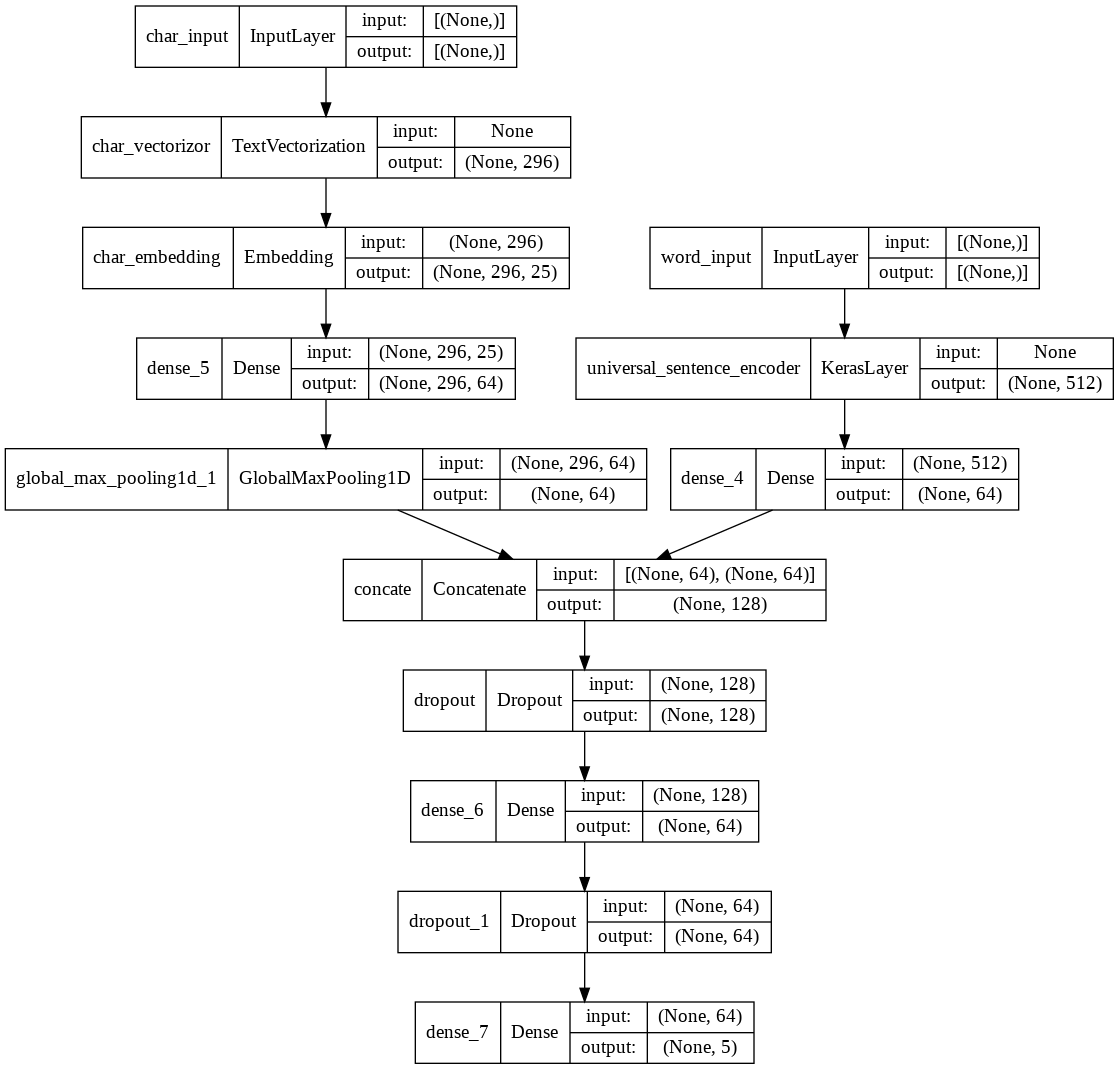

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(model_3,show_shapes=True)

## create appropriate data input

In [51]:
train_word_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_char)) 
train_word_char_labels = tf.data.Dataset.from_tensor_slices(train_label) 
train_word_char_dataset = tf.data.Dataset.zip((train_word_char_data , train_word_char_labels)) 
train_word_char_dataset = train_word_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


val_word_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_char))
val_word_char_labels = tf.data.Dataset.from_tensor_slices(val_label)
val_word_char_dataset = tf.data.Dataset.zip((val_word_char_data, val_word_char_labels))
val_word_char_dataset = val_word_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## fit and evaluation

In [52]:
model_3_history = model_3.fit(train_word_char_dataset, 
                              steps_per_epoch=int(0.3 * len(train_word_char_dataset)),
                              epochs=3,
                              validation_data=val_word_char_dataset,
                              validation_steps=int(0.3 * len(val_word_char_dataset)))

Epoch 1/3
1688/1688 [==============================] - 117s 64ms/step - loss: 0.8150 - accuracy: 0.6867 - val_loss: 0.6065 - val_accuracy: 0.7672
Epoch 2/3
1688/1688 [==============================] - 103s 61ms/step - loss: 0.6784 - accuracy: 0.7520 - val_loss: 0.5676 - val_accuracy: 0.7858
Epoch 3/3
1688/1688 [==============================] - 104s 61ms/step - loss: 0.6493 - accuracy: 0.7626 - val_loss: 0.5548 - val_accuracy: 0.7899


In [53]:
model_3.evaluate(val_word_char_dataset)

945/945 [==============================] - 48s 51ms/step - loss: 0.5579 - accuracy: 0.7910


[0.5578782558441162, 0.7910102009773254]

In [54]:
model_3_predict=model_3.predict(val_word_char_dataset)
model_3_predict_result=tf.argmax(model_3_predict,axis=1)
model_3_result=calculate_results(val_labelencode, model_3_predict_result)
model_3_result

{'accuracy': 0.7910101946246525,
 'f1': 0.7877569932655,
 'precision': 0.7920491344251467,
 'recall': 0.7910101946246525}

# model 4: model 3 + positional layer 


## get 95 percentile for line_number and total_line

In [55]:
train_df.head()

,label,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of 6 weeks of dail...,1,12
1,METHODS,a total of 125 patients with primary knee oa w...,2,12
2,METHODS,outcome measures included pain reduction and i...,3,12
3,METHODS,pain was assessed using the visual analog pain...,4,12
4,METHODS,secondary outcome measures included the wester...,5,12


In [56]:
line_number_percentile=int(np.percentile(train_df.line_number, 95))
line_number_percentile

14

In [57]:
total_line_percentile=int(np.percentile(train_df.total_lines, 95))
total_line_percentile

19

In [58]:
train_line_numbers=tf.one_hot(train_df.line_number.to_numpy(),depth=14)
val_line_numbers=tf.one_hot(val_df.line_number.to_numpy(),depth=14)

In [59]:
train_total_line=tf.one_hot(train_df.total_lines.to_numpy(),depth=19)
val_total_line=tf.one_hot(val_df.total_lines.to_numpy(),depth=19)

## build the model

In [60]:
# word level model
word_input=layers.Input([],dtype=tf.string, name="word_input")
word_embedding=uni_sen_encoder(word_input)
word_output=layers.Dense(64, activation="relu")(word_embedding)
word_model=tf.keras.Model(word_input, word_output)

# character level model
char_input=layers.Input([],dtype=tf.string, name="char_input")
char_vector=char_vectorizor(char_input)
char_embedding_layer=char_embedding(char_vector)
char_dense=layers.Dense(64, activation="relu")(char_embedding_layer)
char_output=layers.GlobalMaxPool1D()(char_dense)
char_model=tf.keras.Model(char_input, char_output)

# concatenate word and char input 
concat=layers.Concatenate(name="concate")([word_model.output,char_model.output])
drop=layers.Dropout(0.5)(concat)
dense=layers.Dense(128, activation="relu")(drop)
drop2=layers.Dropout(0.5)(dense)

# line numbers inputs
line_number_inputs = layers.Input(shape=(line_number_percentile,), name="line_number_input")
x = layers.Dense(64, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# total lines inputs
total_lines_inputs = layers.Input(shape=(total_line_percentile,), name="total_lines_input")
y = layers.Dense(64, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

 # concat line number and total lines
concat2=layers.Concatenate(name="concate2")([line_number_model.output,total_line_model.output])
drop3=layers.Dropout(0.5)(concat2)
dense2=layers.Dense(128, activation="relu")(drop3)
drop4=layers.Dropout(0.5)(dense2)

# final concat
drop4=layers.Concatenate(name="total_concat")([drop4, drop2 ])

final_output=layers.Dense(5, activation="softmax", name="output_layer")(drop4)

model_4=tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 word_model.input, 
                                 char_model.input],
                         outputs=final_output,name="model_4")

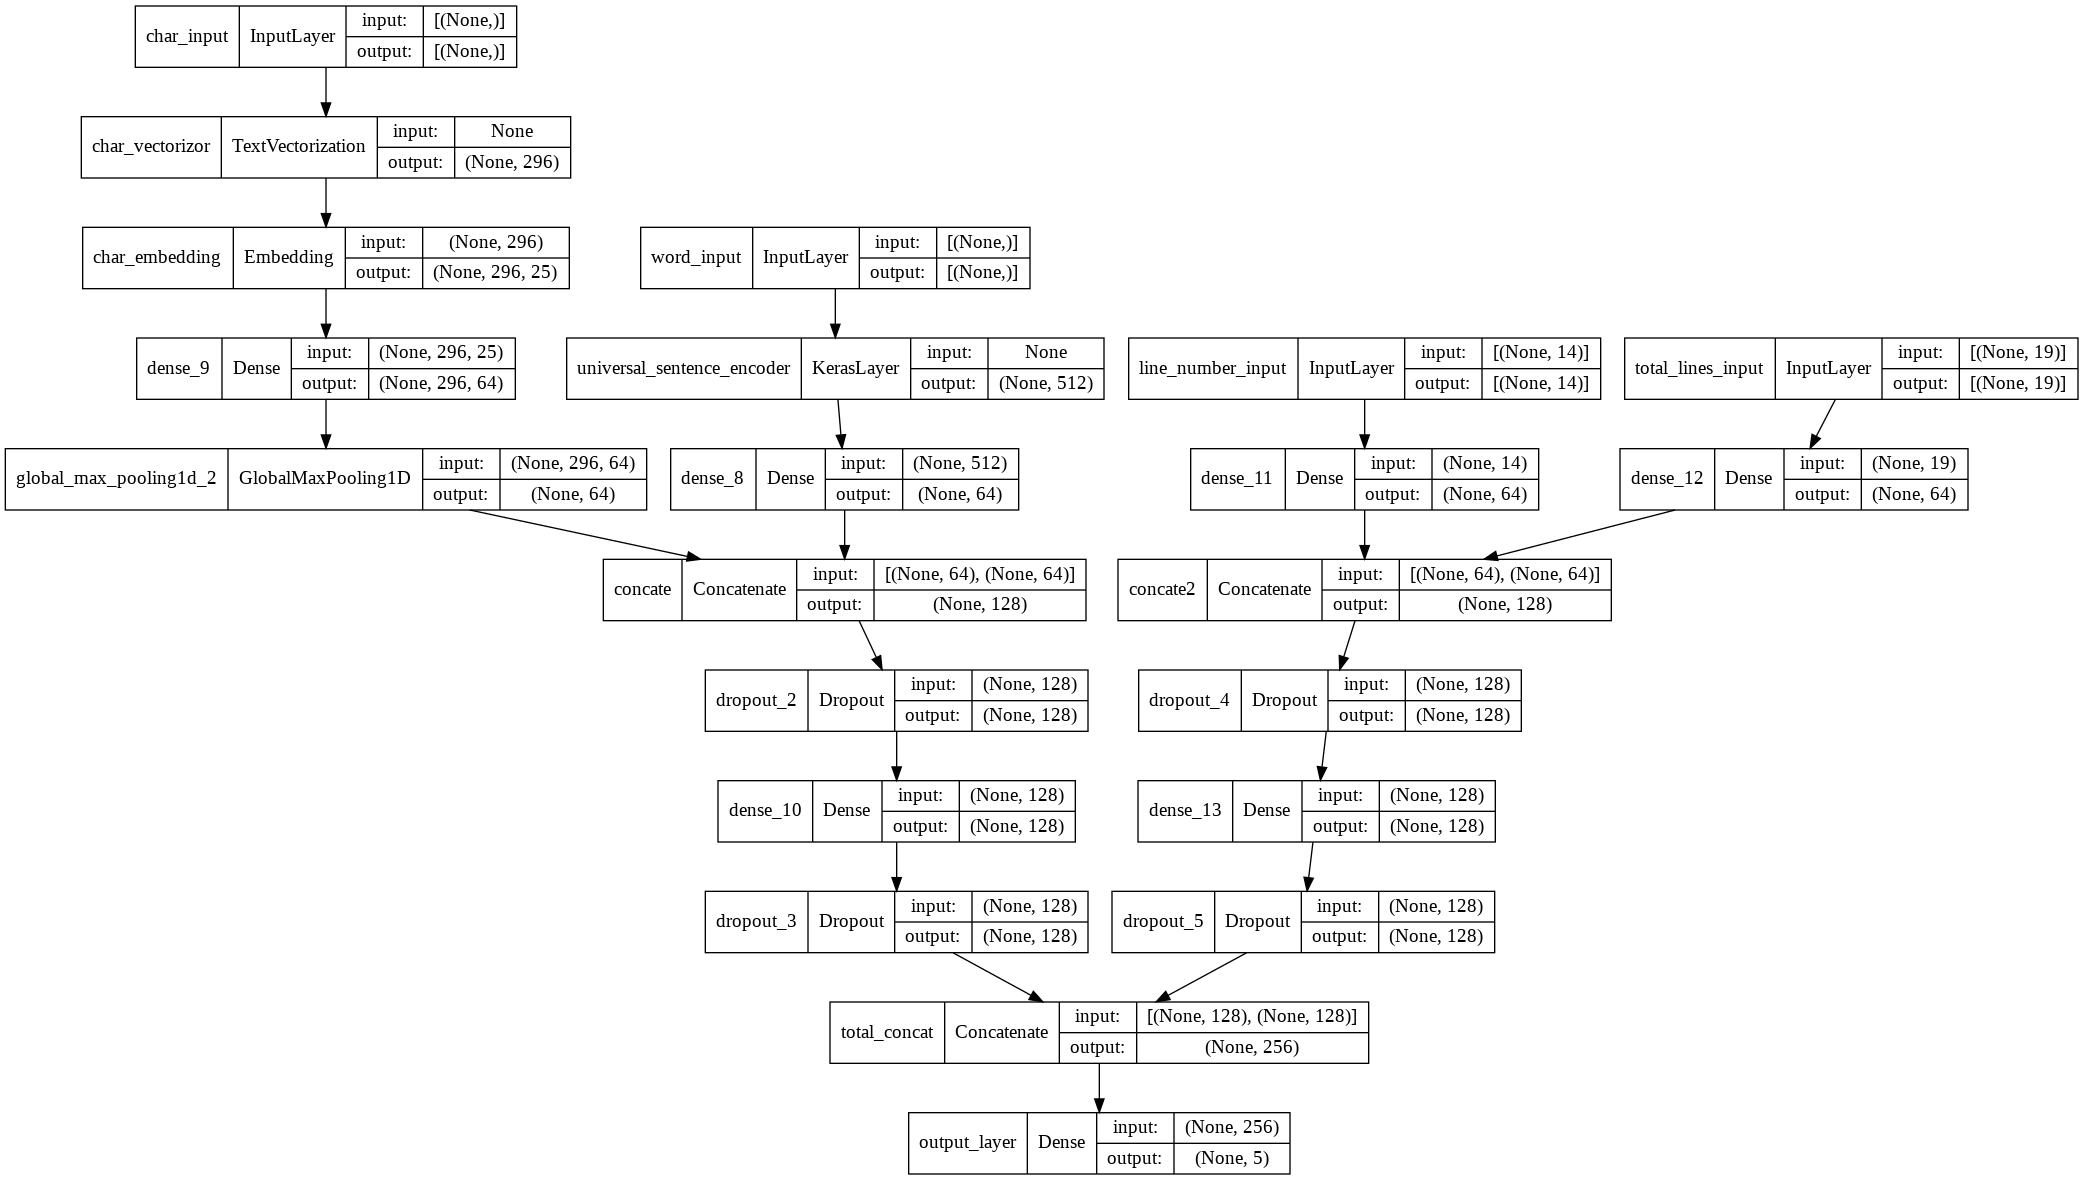

In [61]:
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [62]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.25),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

## prepare data input

In [63]:
train_positional_data=tf.data.Dataset.from_tensor_slices((train_line_numbers,
                                                          train_total_line,
                                                          train_sentences,
                                                          train_char))
train_positional_label=tf.data.Dataset.from_tensor_slices(train_label)
train_positional_dataset=tf.data.Dataset.zip((train_positional_data,train_positional_label))
train_positional_dataset=train_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_positional_data=tf.data.Dataset.from_tensor_slices((val_line_numbers,
                                                        val_total_line,
                                                        val_sentences,
                                                        val_char))
val_positional_label=tf.data.Dataset.from_tensor_slices(val_label)
val_positional_dataset=tf.data.Dataset.zip((val_positional_data,val_positional_label))
val_positional_dataset=val_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [64]:
train_positional_dataset

<PrefetchDataset shapes: (((None, 14), (None, 19), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

## fit and evaluate

In [65]:
mode_4_history=model_4.fit(train_positional_dataset, 
                              steps_per_epoch=int(0.3*len(train_positional_dataset)),
                              epochs=3,
                              validation_data=val_positional_dataset,
                              validation_steps=int(0.3* len(val_positional_dataset)))

Epoch 1/3
1688/1688 [==============================] - 122s 66ms/step - loss: 1.1012 - accuracy: 0.7779 - val_loss: 0.9982 - val_accuracy: 0.8487
Epoch 2/3
1688/1688 [==============================] - 113s 67ms/step - loss: 1.0328 - accuracy: 0.8358 - val_loss: 0.9753 - val_accuracy: 0.8679
Epoch 3/3
1688/1688 [==============================] - 105s 62ms/step - loss: 1.0167 - accuracy: 0.8449 - val_loss: 0.9738 - val_accuracy: 0.8647


In [66]:
model_4.evaluate(val_positional_dataset)

945/945 [==============================] - 49s 52ms/step - loss: 0.9734 - accuracy: 0.8661


[0.9734179973602295, 0.8661128282546997]

In [67]:
model_4_predict=model_4.predict(val_positional_dataset)
model_4_predict_result=tf.argmax(model_4_predict,axis=1)
model_4_result=calculate_results(val_labelencode, model_4_predict_result)
model_4_result

{'accuracy': 0.8661128028597909,
 'f1': 0.8623158685927301,
 'precision': 0.8706624276744844,
 'recall': 0.8661128028597909}

# compare  models

In [90]:
comparison = pd.DataFrame({"naive bayes": model_0_result,
                                  "custom word embedding": model_1_result,
                                  "universal encoder ": model_2_result,
                                  "universal encoder + character embedding": model_3_result,
                                  "USE+character+position": model_4_result
                                  })
comparison = comparison.transpose()
comparison.sort_values("accuracy", ascending=False)

,accuracy,precision,recall,f1
USE+character+position,0.866113,0.870662,0.866113,0.862316
custom word embedding,0.800377,0.809863,0.800377,0.794243
universal encoder + character embedding,0.791010,0.792049,0.791010,0.787757
universal encoder,0.790878,0.794959,0.790878,0.788391
naive bayes,0.731729,0.731517,0.731729,0.705806


# train model 4 with all training data

In [69]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3)
checkpoint_path = "checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [70]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.25),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [71]:
model_4_full_history=model_4.fit(train_positional_dataset, 
                              steps_per_epoch=len(train_positional_dataset),
                              epochs=100,
                              validation_data=val_positional_dataset,
                              validation_steps=len(val_positional_dataset),
                              callbacks=[model_checkpoint, early_stop])

Epoch 1/100
5626/5627 [============================>.] - ETA: 0s - loss: 1.0047 - accuracy: 0.8527INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 426s 74ms/step - loss: 1.0047 - accuracy: 0.8527 - val_loss: 0.9653 - val_accuracy: 0.8688
Epoch 2/100
5626/5627 [============================>.] - ETA: 0s - loss: 0.9971 - accuracy: 0.8580INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 412s 73ms/step - loss: 0.9971 - accuracy: 0.8580 - val_loss: 0.9610 - val_accuracy: 0.8728
Epoch 3/100
5626/5627 [============================>.] - ETA: 0s - loss: 0.9925 - accuracy: 0.8611INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 411s 73ms/step - loss: 0.9925 - accuracy: 0.8611 - val_loss: 0.9601 - val_accuracy: 0.8735
Epoch 4/100
5626/5627 [============================>.] - ETA: 0s - loss: 0.9902 - accuracy: 0.8626INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 410s 73ms/step - loss: 0.9902 - accuracy: 0.8626 - val_loss: 0.9580 - val_accuracy: 0.8749
Epoch 5/100
5626/5627 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.8638INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 412s 73ms/step - loss: 0.9873 - accuracy: 0.8638 - val_loss: 0.9577 - val_accuracy: 0.8778
Epoch 6/100
5626/5627 [============================>.] - ETA: 0s - loss: 0.9857 - accuracy: 0.8658INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 413s 73ms/step - loss: 0.9857 - accuracy: 0.8658 - val_loss: 0.9554 - val_accuracy: 0.8773
Epoch 7/100
5626/5627 [============================>.] - ETA: 0s - loss: 0.9842 - accuracy: 0.8671INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 411s 73ms/step - loss: 0.9842 - accuracy: 0.8671 - val_loss: 0.9550 - val_accuracy: 0.8780
Epoch 8/100
5626/5627 [============================>.] - ETA: 0s - loss: 0.9838 - accuracy: 0.8678INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 409s 73ms/step - loss: 0.9838 - accuracy: 0.8678 - val_loss: 0.9547 - val_accuracy: 0.8791
Epoch 9/100
5627/5627 [==============================] - 343s 61ms/step - loss: 0.9830 - accuracy: 0.8675 - val_loss: 0.9549 - val_accuracy: 0.8782
Epoch 10/100
5626/5627 [============================>.] - ETA: 0s - loss: 0.9819 - accuracy: 0.8683INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 408s 73ms/step - loss: 0.9819 - accuracy: 0.8683 - val_loss: 0.9533 - val_accuracy: 0.8803
Epoch 11/100
5627/5627 [==============================] - 345s 61ms/step - loss: 0.9808 - accuracy: 0.8695 - val_loss: 0.9536 - val_accuracy: 0.8796
Epoch 12/100
5627/5627 [==============================] - 346s 61ms/step - loss: 0.9808 - accuracy: 0.8685 - val_loss: 0.9535 - val_accuracy: 0.8805
Epoch 13/100
5626/5627 [============================>.] - ETA: 0s - loss: 0.9798 - accuracy: 0.8706INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 412s 73ms/step - loss: 0.9798 - accuracy: 0.8706 - val_loss: 0.9532 - val_accuracy: 0.8794
Epoch 14/100
5626/5627 [============================>.] - ETA: 0s - loss: 0.9791 - accuracy: 0.8701INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 418s 74ms/step - loss: 0.9791 - accuracy: 0.8701 - val_loss: 0.9518 - val_accuracy: 0.8803
Epoch 15/100
5626/5627 [============================>.] - ETA: 0s - loss: 0.9793 - accuracy: 0.8701INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


5627/5627 [==============================] - 414s 74ms/step - loss: 0.9793 - accuracy: 0.8701 - val_loss: 0.9515 - val_accuracy: 0.8800
Epoch 16/100
5627/5627 [==============================] - 353s 63ms/step - loss: 0.9784 - accuracy: 0.8709 - val_loss: 0.9534 - val_accuracy: 0.8795
Epoch 17/100
5627/5627 [==============================] - 354s 63ms/step - loss: 0.9776 - accuracy: 0.8722 - val_loss: 0.9521 - val_accuracy: 0.8800
Epoch 18/100
5627/5627 [==============================] - 345s 61ms/step - loss: 0.9779 - accuracy: 0.8715 - val_loss: 0.9520 - val_accuracy: 0.8795


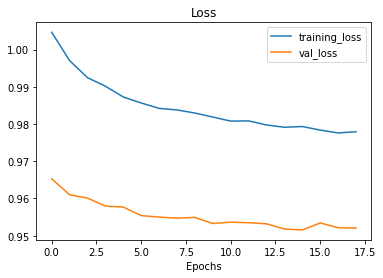

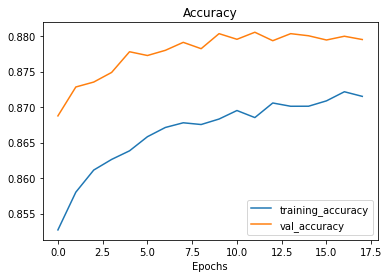

In [72]:
plot_loss_curves(model_4_full_history)

# predict on test data 

In [78]:
test_line_numbers=tf.one_hot(test_df.line_number.to_numpy(),depth=14)
test_total_line=tf.one_hot(test_df.total_lines.to_numpy(),depth=19)

In [74]:
test_positional_data=tf.data.Dataset.from_tensor_slices((test_line_numbers,
                                                                  test_total_line,
                                                                  test_sentences,
                                                                   test_char))
test_positional_label=tf.data.Dataset.from_tensor_slices(test_label)
test_positional_dataset=tf.data.Dataset.zip((test_positional_data,test_positional_label))
test_positional_dataset=test_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [75]:
model_4.evaluate(test_positional_dataset)

942/942 [==============================] - 48s 51ms/step - loss: 0.9579 - accuracy: 0.8756


[0.9579122066497803, 0.8755599856376648]

In [76]:
test_predict=model_4.predict(test_positional_dataset)
test_predict_result=tf.argmax(test_predict,axis=1)
test_result=calculate_results(test_labelencode, test_predict_result)
test_result

{'accuracy': 0.8755599800895968,
 'f1': 0.8727915501750719,
 'precision': 0.8770570816944762,
 'recall': 0.8755599800895968}

# find most wrong prediction and evaluate

In [77]:
test_predict_classes = [label_encoder.classes_[pred] for pred in test_predict_result]

In [92]:
test_df["prediction"] = test_predict_classes
test_df["predict_prob"] = tf.reduce_max(test_predict, axis=1).numpy() 
test_df["result"] = test_df["prediction"] == test_df["label"] 
test_df.head()

,label,text,line_number,total_lines,prediction,predict_prob,result
0,BACKGROUND,this study analyzed liver function abnormaliti...,1,9,OBJECTIVE,0.346936,False
1,RESULTS,a post hoc analysis was conducted with the use...,2,9,METHODS,0.611875,False
2,RESULTS,liver function tests ( lfts ) were measured at...,3,9,METHODS,0.750581,False
3,RESULTS,survival analyses were used to assess the asso...,4,9,METHODS,0.635165,False
4,RESULTS,the percentage of patients with abnormal lfts ...,5,9,RESULTS,0.681376,True


In [94]:
top_wrongs = test_df[test_df.result == False].sort_values("predict_prob", ascending=False)
top_wrongs.head(10)

,label,text,line_number,total_lines,prediction,predict_prob,result
671,METHODS,to determine whether the insulin resistance th...,1,8,OBJECTIVE,0.916867,False
13598,METHODS,-1.5 % vs. fish : -1.4 % vs. fish + s : -0.7 %...,7,10,RESULTS,0.864813,False
14002,METHODS,resulst : graybiel ' s score and grading of se...,7,9,RESULTS,0.863009,False
12082,CONCLUSIONS,comparable numbers of patients experienced bcg...,12,19,RESULTS,0.862854,False
22443,METHODS,this study shows class i evidence that weekly ...,10,10,CONCLUSIONS,0.856183,False
23657,CONCLUSIONS,early reintervention rate within 30 d was thre...,11,15,RESULTS,0.849929,False
12158,METHODS,"in the saffron group , there was no decline in...",10,13,RESULTS,0.849020,False
29638,METHODS,significance for all tests was set at p < .05 .,9,13,RESULTS,0.848712,False
8545,METHODS,pretest-posttest .,2,12,BACKGROUND,0.847964,False
9468,CONCLUSIONS,pdt was associated with a significant decrease...,8,10,RESULTS,0.846433,False


In [95]:
for row in top_wrongs[:30].itertuples(): 
  _, label, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"label: {label}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text: {text}\n\n")

label: METHODS, Pred: OBJECTIVE, Prob: 0.9168668985366821, Line number: 1, Total lines: 8

Text: to determine whether the insulin resistance that exists in metabolic syndrome ( mets ) patients is modulated by dietary fat composition .


label: METHODS, Pred: RESULTS, Prob: 0.8648126125335693, Line number: 7, Total lines: 10

Text: -1.5 % vs. fish : -1.4 % vs. fish + s : -0.7 % ; p < 0.001 ) but there were no significant differences between groups .


label: METHODS, Pred: RESULTS, Prob: 0.8630086183547974, Line number: 7, Total lines: 9

Text: resulst : graybiel ' s score and grading of severity had no difference between two groups through acclimatization training ( p > 0.05 ) .


label: CONCLUSIONS, Pred: RESULTS, Prob: 0.86285400390625, Line number: 12, Total lines: 19

Text: comparable numbers of patients experienced bcg therapy-related side effects in each treatment group ( p = 0.09 ) .


label: METHODS, Pred: CONCLUSIONS, Prob: 0.8561826348304749, Line number: 10, Total lines: 10


In [108]:
top_wrongs200=top_wrongs.iloc[:200,:]
top_wrongs200.groupby("label").count()

,text,line_number,total_lines,prediction,predict_prob,result
label,,,,,,
BACKGROUND,24,24,24,24,24,24
CONCLUSIONS,29,29,29,29,29,29
METHODS,46,46,46,46,46,46
OBJECTIVE,12,12,12,12,12,12
RESULTS,89,89,89,89,89,89


In [114]:
# out of 46 wrong methods prediction, 33 are incorrectly predicted to be results 
wrong_methods=top_wrongs200[top_wrongs200.label=="METHODS"]
wrong_methods[wrong_methods.prediction=="RESULTS"].shape

(33, 7)

In [115]:
# out of 89 wrong results prediction, 88 are incorrectly predicted to be results 
wrong_result=top_wrongs200[top_wrongs200.label=="RESULTS"]
wrong_result[wrong_result.prediction=="METHODS"].shape

(88, 7)

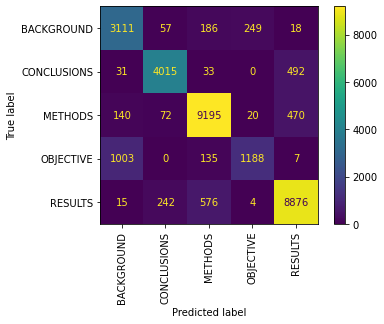

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_df.label, test_predict_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.xticks(rotation="vertical")
plt.show()

# Conclusion 

Among all models built, the model with universal sentence encoder, character embedding and positional embedding presents the best performance on PubMed 20k RCT validation data. Its accuracy on PubMed 20k RCT test data is 0.876. The confusion matrix suggests that overall the model has difficulty in classifying objectives from backgrounds. By ranking wrong predictions based on prediction probability, the table shows that the model has difficulty classifying methods from  results. One plausible reason is that the model built is not equipped to fully  learn the surrounding context. For exmple, "To do" clause usually means objective, but if that clause appears in the abstract where discusses previous studies, it should be classified as background.